CoNLL-2003 dataset task demonstrates the labeling of tokens for named entity recognition (NER), part-of-speech (POS) tagging, and chunking. Each component of the JSON object corresponds to a different layer of annotation for the sentence:

1. **Tokens**: These are the individual words or punctuation marks from the text. In this case, the sentence "EU rejects German call to boycott British lamb." is split into tokens:
   - "EU"
   - "rejects"
   - "German"
   - "call"
   - "to"
   - "boycott"
   - "British"
   - "lamb"
   - "."

2. **POS Tags**: This array contains the POS tags corresponding to each token. The tags are encoded as numbers, each representing a specific part of speech (like noun, verb, adjective). These numbers usually correspond to a tagging scheme such as the Penn Treebank POS tags:
   - "EU" is tagged as 22, which represents a proper noun.
   - "rejects" is tagged as 42, indicating a verb in present tense.
   - And so forth.

3. **Chunk Tags**: This array indicates phrase chunk boundaries and types (like NP for noun phrase, VP for verb phrase). Each number again corresponds to a specific type of phrase or boundary in a predefined scheme:
   - "EU" is part of a noun phrase, hence 11.
   - "rejects" begins a verb phrase, indicated by 21.
   - The chunk tags help in parsing the sentence into linguistically meaningful phrases.

4. **NER Tags**: These tags are used for named entity recognition. They identify whether each token is part of a named entity (like a person, location, organization) and the type of entity:
   - "EU" is tagged as 3, denoting an organization.
   - "German" and "British" are tagged as 7, indicating nationality or ethnicity.
   - Other tokens are tagged as 0, meaning they are not recognized as part of any named entity.

 Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [2]:
!pip install uv
!uv pip install numpy pandas torch transformers datasets scikit-learn umap-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 96.1 MB/s  0:00:006m0:00:01
Using Python 3.12.3 environment at: /home/jj/github/deepl_nlp/.venv
Resolved 80 packages in 300ms                                        
⠙ Preparing packages... (0/77)                                                  
⠙ Preparing packages... (0/77)-------------     0 B/523.63 KiB          
⠙ Preparing packages... (0/77)-------------     0 B/523.63 KiB          
yarl                 ------------------------------     0 B/368.42 KiB
⠙ Preparing packages... (0/77)-------------     0 B/523.63 KiB          
yarl                 ------------------------------     0 B/368.42 KiB
⠙ Preparing packages... (0/77)-------------     0 B/523.63 KiB          
yarl                 ------------------------------     0 B/368.42 KiB
⠙ Preparing packages... (0/77)-------------     0 B/523.63 KiB          
tzdata               ------------------------------     0 B/339.69 KiB
yarl                 --------------------------

# Instructions 
1. download the **conll2003** from the following [link]("https://data.deepai.org/conll2003.zip")
2. unzip the file
3. download the glove embeddings from [link]("https://huggingface.co/datasets/SLU-CSCI4750/glove.6B.100d.txt/resolve/main/glove.6B.100d.txt.gz")
4. unzip the glove embeddings file
5. update the constants in the code below to point to the correct file paths on your machine

In [4]:
# basic python data science tooling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import (
    Dataset, 
    DatasetDict, 
    Features, 
    Sequence, 
    ClassLabel, 
    Value,
)

# progress bar
from tqdm import tqdm


# deep learning stuff
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# constants for config
LOCAL_DIR = "/home/jj/github/deepl_nlp/assignment1/data/conll2003/"
GLOVE_EMBEDS_PATH = '/home/jj/github/deepl_nlp/assignment1/embeddings/glove.6B.100d.txt'

In [5]:
train_file = os.path.join(LOCAL_DIR, "train.txt")
valid_file = os.path.join(LOCAL_DIR, "valid.txt")
test_file = os.path.join(LOCAL_DIR, "test.txt")

pos_names = [
    '"',
    "''",
    "#",
    "$",
    "(",
    ")",
    ",",
    ".",
    ":",
    "``",
    "CC",
    "CD",
    "DT",
    "EX",
    "FW",
    "IN",
    "JJ",
    "JJR",
    "JJS",
    "LS",
    "MD",
    "NN",
    "NNP",
    "NNPS",
    "NNS",
    "NN|SYM",
    "PDT",
    "POS",
    "PRP",
    "PRP$",
    "RB",
    "RBR",
    "RBS",
    "RP",
    "SYM",
    "TO",
    "UH",
    "VB",
    "VBD",
    "VBG",
    "VBN",
    "VBP",
    "VBZ",
    "WDT",
    "WP",
    "WP$",
    "WRB",
]

chunk_names = [
    "O",
    "B-ADJP",
    "I-ADJP",
    "B-ADVP",
    "I-ADVP",
    "B-CONJP",
    "I-CONJP",
    "B-INTJ",
    "I-INTJ",
    "B-LST",
    "I-LST",
    "B-NP",
    "I-NP",
    "B-PP",
    "I-PP",
    "B-PRT",
    "I-PRT",
    "B-SBAR",
    "I-SBAR",
    "B-UCP",
    "I-UCP",
    "B-VP",
    "I-VP",
]

ner_names = [
    "O",
    "B-PER",
    "I-PER",
    "B-ORG",
    "I-ORG",
    "B-LOC",
    "I-LOC",
    "B-MISC",
    "I-MISC",
]


def parse_conll(path: str):
    """Parse a CoNLL-2003 file into a list of examples."""
    examples = []
    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            if line.startswith("-DOCSTART-") or line.strip() == "":
                if tokens:
                    examples.append(
                        {
                            "tokens": tokens,
                            "pos_tags": pos_tags,
                            "chunk_tags": chunk_tags,
                            "ner_tags": ner_tags,
                        }
                    )
                    tokens, pos_tags, chunk_tags, ner_tags = [], [], [], []
            else:
                splits = line.rstrip().split(" ")
                tokens.append(splits[0])
                pos_tags.append(splits[1])
                chunk_tags.append(splits[2])
                ner_tags.append(splits[3])
    if tokens:
        examples.append(
            {
                "tokens": tokens,
                "pos_tags": pos_tags,
                "chunk_tags": chunk_tags,
                "ner_tags": ner_tags,
            }
        )
    return examples


def as_dataset(examples, features: Features):
    ids = []
    tokens_col, pos_col, chunk_col, ner_col = [], [], [], []
    for i, ex in enumerate(examples):
        ids.append(str(i))
        tokens_col.append(ex["tokens"])
        pos_col.append(ex["pos_tags"])
        chunk_col.append(ex["chunk_tags"])
        ner_col.append(ex["ner_tags"])
    return Dataset.from_dict(
        {
            "id": ids,
            "tokens": tokens_col,
            "pos_tags": pos_col,
            "chunk_tags": chunk_col,
            "ner_tags": ner_col,
        },
        features=features,
    )


features = Features(
    {
        "id": Value("string"),
        "tokens": Sequence(Value("string")),
        "pos_tags": Sequence(ClassLabel(names=pos_names)),
        "chunk_tags": Sequence(ClassLabel(names=chunk_names)),
        "ner_tags": Sequence(ClassLabel(names=ner_names)),
    }
)

train_examples = parse_conll(train_file)
valid_examples = parse_conll(valid_file)
test_examples = parse_conll(test_file)

conll2003 = DatasetDict(
    {
        "train": as_dataset(train_examples, features),
        "validation": as_dataset(valid_examples, features),
        "test": as_dataset(test_examples, features),
    }
)

display(conll2003)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [6]:
print(conll2003['train'][0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [7]:
def load_glove_embeddings(file_path, embedding_dim):
    # dict to store word embed vectors
    word_vectors = {}
    with open(file_path, 'r', encoding='utf - 8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor(
                [float(val) for val in values[1:]], dtype=torch.float32)
            word_vectors[word] = vector

    # matrix of embeddings
    vocab_size = len(word_vectors)
    embedding_matrix = torch.zeros((vocab_size, embedding_dim))
    word_to_idx = {}
    idx_to_word = {}
    for i, (word, vector) in enumerate(word_vectors.items()):
        embedding_matrix[i] = vector
        word_to_idx[word] = i
        idx_to_word[i] = word

    return embedding_matrix, word_to_idx, idx_to_word


embedding_dim = 100
embedding_matrix, word_to_idx, idx_to_word = load_glove_embeddings(GLOVE_EMBEDS_PATH, embedding_dim)


embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
embedding_layer

Embedding(400000, 100)

In [8]:
UNK_IDX = len(word_to_idx)

def tokens_to_indices(tokens_batch):
    indices = []
    for tokens in tokens_batch:
        idxs = [
            word_to_idx.get(t.lower(), UNK_IDX) for t in tokens
        ]
        indices.append(torch.tensor(idxs, dtype=torch.long))
    return indices


def labels_to_tensors(labels_batch):
    return [torch.tensor(lbls, dtype=torch.long) for lbls in labels_batch]


def collate_fn(batch):
    input_ids = tokens_to_indices([b["tokens"] for b in batch])
    labels = labels_to_tensors([b["ner_tags"] for b in batch])
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=UNK_IDX)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    return {"input_ids": input_ids, "labels": labels}


train_dataloader = DataLoader(conll2003["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(conll2003["validation"], batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(conll2003["test"], batch_size=32, collate_fn=collate_fn)

In [ ]:

class LinearNER(nn.Module):
    """
    Simple linear model for Named Entity Recognition using GloVe embeddings.
    Architecture: Embedding -> Linear -> Logits
    """
    def __init__(self, embedding_matrix: torch.Tensor, num_tags: int):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        
        # Create embedding layer with extra slot for unknown tokens (UNK)
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        
        # Initialize embeddings with pre-trained GloVe vectors
        # The last row (index vocab_size) is reserved for UNK tokens and initialized to zeros
        with torch.no_grad():
            self.embedding.weight[:vocab_size].copy_(embedding_matrix)
            self.embedding.weight[vocab_size].zero_()
        
        # Linear classifier maps embedding dimension to number of NER tags
        self.classifier = nn.Linear(embed_dim, num_tags)

    def forward(self, input_ids):
        """
        Args:
            input_ids: (batch_size, sequence_length) - token indices
        Returns:
            logits: (batch_size, sequence_length, num_tags) - unnormalized scores for each tag
        """
        emb = self.embedding(input_ids)           # (B, T, D) - embed each token
        logits = self.classifier(emb)             # (B, T, C) - project to tag space
        return logits


# Get number of NER tags from dataset (e.g., O, B-PER, I-PER, B-ORG, etc.)
num_tags = len(conll2003["train"].features["ner_tags"].feature.names)

# Initialize model with pre-trained GloVe embeddings
model = LinearNER(embedding_matrix, num_tags)

# CrossEntropyLoss with ignore_index=-100 to skip padding tokens in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=-100)

# Adam optimizer for parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0
    
    for batch in train_dataloader:
        # Move batch data to device
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        # Zero gradients from previous step
        optimizer.zero_grad()
        
        # Forward pass: get predictions
        logits = model(input_ids)
        
        # Compute loss (flatten to 2D for CrossEntropyLoss: [batch*seq_len, num_tags])
        loss = criterion(logits.view(-1, num_tags), labels.view(-1))
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss for monitoring
        total_loss += loss.item()
    
    # Print average loss per batch for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_dataloader):.4f}")


Epoch 1/3 - Train Loss: 0.6427
Epoch 2/3 - Train Loss: 0.2932
Epoch 3/3 - Train Loss: 0.2161


Homework: 
Load a NER dataset (e.g. CoNLL-2003) using the script provided below.
   - Create a custom nn.Module class that takes Glove word embeddings as input, passes them through a linear layer, and outputs NER tags
   - Train the model using cross-entropy loss and evaluate its performance using entity-level F1 score
   - Analyze the model's predictions and visualize the confusion matrix to identify common errors
2. Build a multi-layer perceptron (MLP) for NER using Glove embeddings
   - Extend the previous exercise by creating an nn.Module class that defines an MLP architecture on top of Glove embeddings
   - Experiment with different hidden layer sizes and number of layers
   - Evaluate the trained model using entity-level precision, recall, and F1 scores
   - Compare the performance of the MLP model with the simple linear model from exercise 
   - 1
3. Explore the effects of different activation functions and regularization techniques for NER
   - Modify the MLP model from exercise 2 to allow configurable activation functions (e.g. ReLU, tanh, sigmoid)
   - Train models with different activation functions.)
   - Visualize the learned entity embeddings using dimensionality reduction techniques like PCA or t-SNE (edited) 
   - 

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict

def get_entities(tags, tag_names):
    """
    Extract entities from a sequence of NER tags.
    Returns a list of tuples: (entity_type, start_idx, end_idx)
    """
    entities = []
    current_entity = None
    
    for i, tag_id in enumerate(tags):
        if tag_id == -100:  # padding
            continue
        tag = tag_names[tag_id]
        
        if tag.startswith('B-'):
            # Save previous entity if exists
            if current_entity is not None:
                entities.append(current_entity)
            # Start new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            current_entity = (entity_type, i, i)
        elif tag.startswith('I-'):
            # Continue current entity
            entity_type = tag[2:]  # Remove 'I-' prefix
            if current_entity is not None and current_entity[0] == entity_type:
                current_entity = (current_entity[0], current_entity[1], i)
            else:
                # Mismatched I- tag, treat as new entity
                if current_entity is not None:
                    entities.append(current_entity)
                current_entity = (entity_type, i, i)
        else:  # 'O' tag
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None
    
    # Don't forget the last entity
    if current_entity is not None:
        entities.append(current_entity)
    
    return set(entities)


def compute_entity_f1(model, dataloader, tag_names, device):
    """
    Compute entity-level precision, recall, and F1 score.
    """
    model.eval()
    
    all_true_entities = []
    all_pred_entities = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Process each sequence in the batch
            for pred_seq, true_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                # Extract entities
                true_entities = get_entities(true_seq, tag_names)
                pred_entities = get_entities(pred_seq, tag_names)
                
                all_true_entities.append(true_entities)
                all_pred_entities.append(pred_entities)
    
    # Calculate metrics
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for true_ents, pred_ents in zip(all_true_entities, all_pred_entities):
        true_positives += len(true_ents & pred_ents)  # Intersection
        false_positives += len(pred_ents - true_ents)  # Predicted but not true
        false_negatives += len(true_ents - pred_ents)  # True but not predicted
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }


# Get tag names
tag_names = conll2003["train"].features["ner_tags"].feature.names

# Evaluate on validation set
print("=" * 60)
print("Entity-level Evaluation on Validation Set")
print("=" * 60)
val_metrics = compute_entity_f1(model, val_dataloader, tag_names, device)
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall:    {val_metrics['recall']:.4f}")
print(f"F1 Score:  {val_metrics['f1']:.4f}")
print(f"\nTrue Positives:  {val_metrics['true_positives']}")
print(f"False Positives: {val_metrics['false_positives']}")
print(f"False Negatives: {val_metrics['false_negatives']}")

# Evaluate on test set
print("\n" + "=" * 60)
print("Entity-level Evaluation on Test Set")
print("=" * 60)
test_metrics = compute_entity_f1(model, test_dataloader, tag_names, device)
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"\nTrue Positives:  {test_metrics['true_positives']}")
print(f"False Positives: {test_metrics['false_positives']}")
print(f"False Negatives: {test_metrics['false_negatives']}")

Entity-level Evaluation on Validation Set


Evaluating: 100%|██████████| 102/102 [00:00<00:00, 574.49it/s]


Precision: 0.6041
Recall:    0.6961
F1 Score:  0.6469

True Positives:  4136
False Positives: 2710
False Negatives: 1806

Entity-level Evaluation on Test Set


Evaluating: 100%|██████████| 108/108 [00:00<00:00, 664.03it/s]

Precision: 0.5367
Recall:    0.6353
F1 Score:  0.5819

True Positives:  3588
False Positives: 3097
False Negatives: 2060


Getting predictions: 100%|██████████| 108/108 [00:00<00:00, 687.05it/s]


Token-level Classification Report (Test Set)
              precision    recall  f1-score   support

           O     0.9654    0.9800    0.9726     38323
       B-PER     0.7193    0.6673    0.6923      1617
       I-PER     0.5688    0.5147    0.5404      1156
       B-ORG     0.6802    0.6069    0.6414      1661
       I-ORG     0.5446    0.2922    0.3804       835
       B-LOC     0.7144    0.8519    0.7771      1668
       I-LOC     0.5602    0.4708    0.5116       257
      B-MISC     0.6334    0.6154    0.6243       702
      I-MISC     0.5422    0.4167    0.4712       216

    accuracy                         0.9163     46435
   macro avg     0.6587    0.6018    0.6235     46435
weighted avg     0.9109    0.9163    0.9124     46435



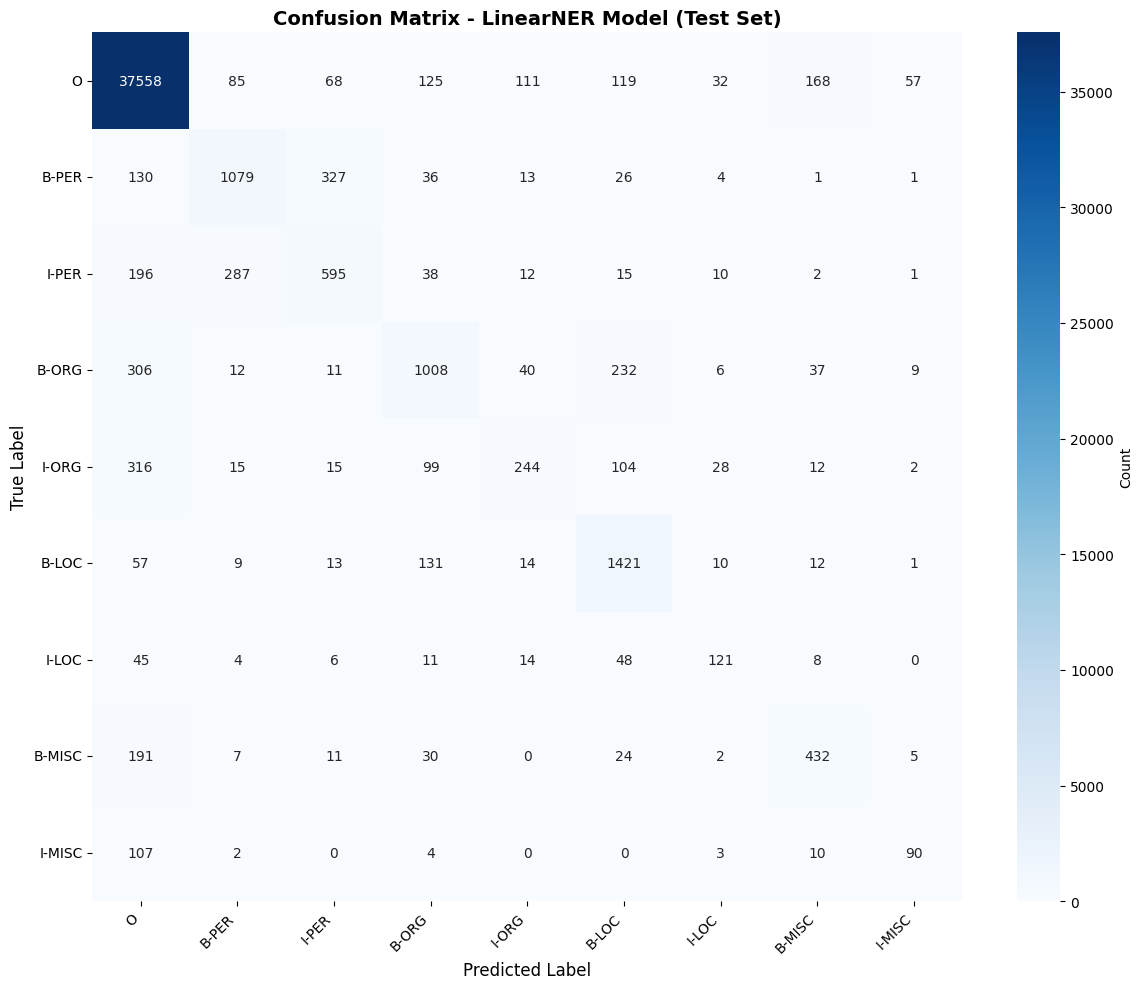


Top 10 Most Common Prediction Errors
True: B-PER      -> Predicted: I-PER      | Count: 327
True: I-ORG      -> Predicted: O          | Count: 316
True: B-ORG      -> Predicted: O          | Count: 306
True: I-PER      -> Predicted: B-PER      | Count: 287
True: B-ORG      -> Predicted: B-LOC      | Count: 232
True: I-PER      -> Predicted: O          | Count: 196
True: B-MISC     -> Predicted: O          | Count: 191
True: O          -> Predicted: B-MISC     | Count: 168
True: B-LOC      -> Predicted: B-ORG      | Count: 131
True: B-PER      -> Predicted: O          | Count: 130


In [11]:
# Token-level confusion matrix and classification report
def get_token_predictions(model, dataloader, device):
    """Get all predictions and labels at token level (excluding padding)."""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            logits = model(input_ids)
            predictions = torch.argmax(logits, dim=-1)
            
            # Flatten and filter out padding tokens
            for pred_seq, label_seq in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
                for pred, label in zip(pred_seq, label_seq):
                    if label != -100:  # Ignore padding
                        all_preds.append(pred)
                        all_labels.append(label)
    
    return np.array(all_preds), np.array(all_labels)


# Get predictions
print("Collecting predictions for confusion matrix...")
preds, labels = get_token_predictions(model, test_dataloader, device)

# Classification report
print("\n" + "=" * 60)
print("Token-level Classification Report (Test Set)")
print("=" * 60)
print(classification_report(labels, preds, target_names=tag_names, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tag_names, yticklabels=tag_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - LinearNER Model (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze most common errors
print("\n" + "=" * 60)
print("Top 10 Most Common Prediction Errors")
print("=" * 60)
errors = []
for i in range(len(tag_names)):
    for j in range(len(tag_names)):
        if i != j and cm[i, j] > 0:
            errors.append((tag_names[i], tag_names[j], cm[i, j]))

errors.sort(key=lambda x: x[2], reverse=True)
for true_tag, pred_tag, count in errors[:10]:
    print(f"True: {true_tag:10s} -> Predicted: {pred_tag:10s} | Count: {count}")